In [7]:
# Run in parent directory
import os
if os.getcwd().split('/')[-1] != 'tinyRNN':
    os.chdir('..')
assert os.getcwd().split('/')[-1] == 'tinyRNN'

In [15]:
import numpy as np

import sys
sys.path.append(os.getcwd() + '/simulating_experiments')
sys.path.append(os.getcwd() + '/plotting_experiments')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate simulated dataset

This is not the typical place to start for a data analysis, but it helps connect all the pieces together with a simple task.

## Make a task

Here, we're examining a simple 2-armed Bernoulli bandit, where each arm's reward probability is sampled uniformly from $[0, 1]$.

In [16]:
class MultiArmedBandit:
    '''2-armed Bernoulli bandit'''
    def __init__(self, n_actions=2):
        self.n_actions = n_actions

    def reset(self, n_trials=None):
        self.probs = np.random.uniform(0, 1, size=self.n_actions)

    def trial(self, choice):
        outcome = np.random.binomial(1, self.probs[choice])
        return (choice, outcome)

## Initialize MF agent

For our agent, we'll use a simple model-free RL agent.

In [17]:
from agents.MABCogAgent import MABCogAgent

mf = MABCogAgent(dict(cog_type='MF', n_actions=2))
mf.model.params[mf.model.param_names.index('iTemp')] = 2.

In [18]:
mf.simulate(MultiArmedBandit(), 5, get_DVs=True)

{'Q_td': array([[0.   , 0.   ],
        [0.   , 0.   ],
        [0.   , 0.   ],
        [0.   , 0.5  ],
        [0.   , 0.75 ],
        [0.   , 0.875]]),
 'scores': array([[0.  , 0.  ],
        [0.  , 0.  ],
        [0.  , 0.  ],
        [0.  , 1.  ],
        [0.  , 1.5 ],
        [0.  , 1.75]]),
 'choice_probs': array([[0.5       , 0.5       ],
        [0.5       , 0.5       ],
        [0.5       , 0.5       ],
        [0.26894142, 0.73105858],
        [0.18242552, 0.81757448],
        [0.1480472 , 0.8519528 ]]),
 'trial_log_likelihood': array([-0.69314718, -0.69314718, -0.69314718, -0.31326169, -0.20141328]),
 'session_log_likelihood': np.float64(-2.594116507180811),
 'n_trials': 5,
 'choices': array([0, 0, 1, 1, 1]),
 'second_steps': array([0, 0, 1, 1, 1]),
 'outcomes': array([0, 0, 1, 1, 1])}

## Showing the data format

Here, we are sampling a small dataset in order to show the relevant keys for a dataset. In particular, a dataset should contain the following key/value pairs, where each value is a list (for each block) of arrays (for each block's trial).

- `action`, which is the action taken at the current trial.
- `reward`, which is the reward received at the current trial, as a result of the action.
- `stage2`, which is the observation received at the current trial, as a result of the action.

The `trial_type` field is important for visualization later on, but can be left out when initially coding things up.

In [19]:
from simulating_experiments.simulate_experiment import simulate_exp
config = dict(
    n_blocks=3, n_trials=5, sim_seed=42, sim_exp_name='test', additional_name='',
    task='BartoloMonkey',
)
_ = simulate_exp(mf, MultiArmedBandit(), config)

from datasets.dataset_utils import Dataset
ds = Dataset(
    'SimAgent',
    behav_data_spec={
        'agent_path': ['test'],
        'agent_name': 'MF_seed42',
    },
    verbose=False
)
ds.behav_to(dict(behav_format='tensor'))
print(ds.behav.keys())
relevant_keys = ['action', 'stage2', 'reward', 'trial_type']
{
    k: ds.behav[k]
    for k in relevant_keys
}

Simulating agent MF with params [0.5, 2.0]
n_blocks 3 n_trials 5 sim_seed 42 sim_exp_name test additional_name 
dict_keys(['action', 'stage2', 'reward', 'params', 'mid_vars', 'trial_type'])


{'action': [array([1, 0, 1, 1, 1]),
  array([1, 1, 0, 1, 0]),
  array([0, 1, 0, 0, 1])],
 'stage2': [array([1, 0, 1, 1, 1]),
  array([1, 1, 0, 1, 0]),
  array([0, 1, 0, 0, 1])],
 'reward': [array([1, 0, 1, 1, 1]),
  array([0, 1, 0, 0, 1]),
  array([0, 0, 0, 0, 0])],
 'trial_type': [array([3, 0, 3, 3, 3]),
  array([2, 3, 0, 2, 1]),
  array([0, 2, 0, 0, 2])]}

## Generate a larger dataset for training

In [20]:
from simulating_experiments.simulate_experiment import simulate_exp
config = dict(
    n_blocks=500, n_trials=20, sim_seed=42, sim_exp_name='test', additional_name='',
    task='BartoloMonkey',
)
_ = simulate_exp(mf, MultiArmedBandit(), config)

Simulating agent MF with params [0.5, 2.0]
n_blocks 500 n_trials 20 sim_seed 42 sim_exp_name test additional_name 


# Training

Note: this will take a few minutes! But subsequent executions will load saved model.

In [21]:
from training_experiments.training import behavior_cv_training_config_combination

base_config = {
      ### dataset info
      'dataset': 'SimAgent',
      'behav_data_spec': {
        'agent_path': ['test'],
        'agent_name': 'MF_seed42',
      },

      ### model info
      'behav_format': 'tensor',
      'agent_type': 'RNN',
      'rnn_type': 'GRU', # which rnn layer to use
      'include_embedding': False,
      'input_dim': 3,
      'hidden_dim': 2, # dimension of this rnn layer
      'output_dim': 2, # dimension of action
      'output_h0': True, # whether initial hidden state included in loss
      'trainable_h0': False, # the agent's initial hidden state trainable or not
      'readout_FC': True, # whether the readout layer is full connected or not
      'one_hot': False, # whether the data input is one-hot or not

      'device': 'cpu',
      ### training info for one model
      'lr': 0.005,
      'l1_weight': 1e-5,
      'weight_decay': 0,
      'penalized_weight': 'rec',
      'max_epoch_num': 10000,
      'early_stop_counter': 200,
      'batch_size': 0, # no mini-batch
      ### training info for many models on dataset
      'outer_splits': 3,
      'inner_splits': 2,
      # 'single_inner_fold': True,
      'seed_num': 2,

      ### additional training info
      'save_model_pass': 'minimal', # 'full' for saving all results; 'minimal' for saving only the losses; 'none' for not saving results
      'training_diagnose': [], # can be a list of diagnose function strings

      ### current training exp path
      'exp_folder': 'sim_mf',
}

config_ranges = { # keys are used to generate model names
    #   'rnn_type': ['GRU'],
      'hidden_dim': [1,2],
    #   'l1_weight': [1e-5],
}

behavior_cv_training_config_combination(base_config, config_ranges, n_jobs=1, verbose_level=1)

{'dataset': 'SimAgent',
 'behav_data_spec': {'agent_path': ['test'], 'agent_name': 'MF_seed42'},
 'behav_format': 'tensor',
 'agent_type': 'RNN',
 'rnn_type': 'GRU',
 'include_embedding': False,
 'input_dim': 3,
 'hidden_dim': 1,
 'output_dim': 2,
 'output_h0': True,
 'trainable_h0': False,
 'readout_FC': True,
 'one_hot': False,
 'device': 'cpu',
 'lr': 0.005,
 'l1_weight': 1e-05,
 'weight_decay': 0,
 'penalized_weight': 'rec',
 'max_epoch_num': 10000,
 'early_stop_counter': 200,
 'batch_size': 0,
 'outer_splits': 3,
 'inner_splits': 2,
 'seed_num': 2,
 'save_model_pass': 'minimal',
 'training_diagnose': [],
 'exp_folder': 'sim_mf',
 'model_path': 'sim_mf/hidden_dim-1'}
Data block num 500


/Users/carlos/pd/tinyRNN/agents/RNNAgentTrainer.py:137: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.use_amp)


Start 4 agents training with 1 processes.


  0%|          | 20/10001 [00:00<00:51, 192.67it/s]

Epoch 0, train loss 0.7083, val loss 0.7008, test loss 0.7173


  1%|▏         | 149/10001 [00:00<00:38, 256.76it/s]

Epoch 100, train loss 0.6289, val loss 0.6249, test loss 0.6294


  2%|▏         | 229/10001 [00:00<00:37, 262.01it/s]

Epoch 200, train loss 0.6036, val loss 0.5998, test loss 0.6047


  3%|▎         | 340/10001 [00:01<00:36, 265.37it/s]

Epoch 300, train loss 0.5978, val loss 0.5952, test loss 0.6007


  4%|▍         | 447/10001 [00:01<00:37, 256.18it/s]

Epoch 400, train loss 0.5952, val loss 0.5936, test loss 0.5992


  5%|▌         | 527/10001 [00:02<00:39, 242.66it/s]

Epoch 500, train loss 0.5938, val loss 0.5929, test loss 0.5985


  6%|▋         | 628/10001 [00:02<00:39, 234.92it/s]

Epoch 600, train loss 0.5928, val loss 0.5924, test loss 0.5979


  7%|▋         | 737/10001 [00:02<00:35, 257.95it/s]

Epoch 700, train loss 0.5920, val loss 0.5919, test loss 0.5972


  8%|▊         | 818/10001 [00:03<00:39, 231.41it/s]

Epoch 800, train loss 0.5913, val loss 0.5915, test loss 0.5966


  9%|▉         | 940/10001 [00:03<00:42, 214.68it/s]

Epoch 900, train loss 0.5909, val loss 0.5912, test loss 0.5962


 10%|█         | 1048/10001 [00:04<00:34, 256.28it/s]

Epoch 1000, train loss 0.5906, val loss 0.5911, test loss 0.5959


 11%|█▏        | 1130/10001 [00:04<00:33, 265.64it/s]

Epoch 1100, train loss 0.5904, val loss 0.5910, test loss 0.5958


 12%|█▏        | 1246/10001 [00:05<00:31, 278.88it/s]

Epoch 1200, train loss 0.5902, val loss 0.5910, test loss 0.5956


 13%|█▎        | 1331/10001 [00:05<00:31, 278.97it/s]

Epoch 1300, train loss 0.5899, val loss 0.5910, test loss 0.5953


 14%|█▎        | 1365/10001 [00:05<00:34, 249.23it/s]
/Users/carlos/pd/tinyRNN/agents/RNNAgent.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(M

Model outerfold0_innerfold0_seed0 Training done. time cost: 5.509942054748535 best train loss: 0.590229854543221 best val loss: 0.5909587764086706 best test loss: 0.5956446974885891
Agent sim_mf/hidden_dim-1/outerfold0_innerfold0_seed1 already trained. Skip training.
Agent sim_mf/hidden_dim-1/outerfold0_innerfold1_seed0 already trained. Skip training.
Agent sim_mf/hidden_dim-1/outerfold0_innerfold1_seed1 already trained. Skip training.
Finished 4 agents training with 1 processes. Time used: 5.647s
   outer_fold  inner_fold  seed  test_loss  trainval_loss  train_loss  val_loss  test_trial_num  trainval_trial_num  train_trial_num  val_trial_num                                         test_index                                        train_index                                          val_index                                       model_path                                             config
0           0           0     0   0.595645       0.590595    0.590230  0.590959          3340.0 

# Identify best models

In [22]:
from analyzing_experiments.analyzing_perf import find_best_models_for_exp

exp_folder = 'sim_mf'
find_best_models_for_exp(
    exp_folder, 'MABCog',
    additional_rnn_keys={'model_identifier_keys': ['block','distill','pretrained', 'distill_temp','teacher_prop',],},
    rnn_sort_keys=['block', 'hidden_dim'],
    has_rnn=True,
    has_cog=False,
    return_dim_est=True,
    include_acc=True,
    check_missing=False,
)


========Select best models based on inner_fold_perf_key: trainval_loss exp_folder: sim_mf
Searching for summary files...
Found 2 summary files.
Filtering by {'agent_type': 'RNN'}


100%|██████████| 2/2 [00:00<00:00, 952.39it/s]

sim_mf/hidden_dim-1/outerfold0_innerfold0_seed1
Total trial num: 10000
sim_mf/hidden_dim-1/outerfold0_innerfold1_seed0
sim_mf/hidden_dim-1/outerfold1_innerfold0_seed0
sim_mf/hidden_dim-1/outerfold1_innerfold1_seed1
sim_mf/hidden_dim-1/outerfold2_innerfold0_seed1
sim_mf/hidden_dim-1/outerfold2_innerfold1_seed0
sim_mf/hidden_dim-2/outerfold0_innerfold0_seed0
sim_mf/hidden_dim-2/outerfold0_innerfold1_seed1
sim_mf/hidden_dim-2/outerfold1_innerfold0_seed0
sim_mf/hidden_dim-2/outerfold1_innerfold1_seed0
sim_mf/hidden_dim-2/outerfold2_innerfold0_seed0
sim_mf/hidden_dim-2/outerfold2_innerfold1_seed1



/Users/carlos/pd/tinyRNN/agents/RNNAgent.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(MODEL_SAVE_PATH / model_path / 'model.ckpt', map_locat

   block  test_loss  trainval_loss  train_loss  val_loss  test_acc  trainval_acc  train_acc  val_acc  hidden_dim rnn_type  readout_FC distill pretrained distill_temp teacher_prop agg_outer_fold                                                 agg_test_loss  total_test_loss  test_trial_num  total_trainval_loss  trainval_trial_num  total_train_loss  train_trial_num  total_val_loss  val_trial_num  test_loss_outer_std  test_loss_outer_sem  mean_train_trial_num  mean_val_trial_num                                                  agg_test_acc  total_test_acc  total_trainval_acc  total_train_acc  total_val_acc  test_acc_outer_std  test_acc_outer_sem  test_loss_mean_inner_sem  test_loss_outer_inner_sem  test_acc_mean_inner_sem  test_acc_outer_inner_sem
0     -1   0.591478       0.589980    0.588522  0.591438    0.6823       0.68080     0.6831   0.6785           1      GRU        True    none       none         none         none      [0, 1, 2]  [0.5938518921940109, 0.5964991126230937, 0.58403968

# Get model scores

This gets the predictions from models, making sure to get the appropriate model for each fold of the data.

In [23]:
from analyzing_experiments.analyzing_perf import run_scores_exp

run_scores_exp(
    exp_folder, demask=False,
    pointwise_loss=False,
    model_filter={'distill': 'none', 'rnn_type': 'GRU'},
    overwrite_config={
        # 'behav_data_spec': {'augment': True},
        'device': 'cpu',
    },
    include_data='all',
    has_cog=False,
)


files/analysis/sim_mf
filter rnn_summary by distill=none
filter rnn_summary by rnn_type=GRU
sim_mf/hidden_dim-1/outerfold0_innerfold0_seed1
Total trial num: 10000
sim_mf/hidden_dim-1/outerfold1_innerfold1_seed1


/Users/carlos/pd/tinyRNN/agents/RNNAgent.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(MODEL_SAVE_PATH / model_path / 'model.ckpt', map_locati

Total trial num: 10000
sim_mf/hidden_dim-1/outerfold2_innerfold1_seed0
Total trial num: 10000
sim_mf/hidden_dim-2/outerfold0_innerfold0_seed0
Total trial num: 10000
sim_mf/hidden_dim-2/outerfold1_innerfold1_seed0
Total trial num: 10000
sim_mf/hidden_dim-2/outerfold2_innerfold0_seed0
Total trial num: 10000


# Make a logit plot

In sim_mf. Found 6 models
Found 6 models after filtering
sim_mf/hidden_dim-1/outerfold0_innerfold0_seed1 making ['2d_logit_change']


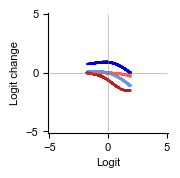

sim_mf/hidden_dim-1/outerfold1_innerfold1_seed1 making ['2d_logit_change']


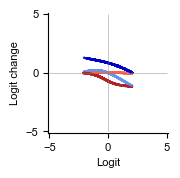

sim_mf/hidden_dim-1/outerfold2_innerfold1_seed0 making ['2d_logit_change']


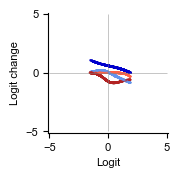

sim_mf/hidden_dim-2/outerfold0_innerfold0_seed0 making ['2d_logit_change']


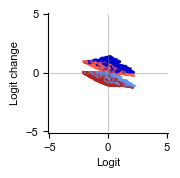

sim_mf/hidden_dim-2/outerfold1_innerfold1_seed0 making ['2d_logit_change']


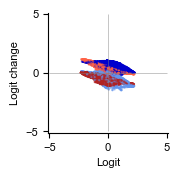

sim_mf/hidden_dim-2/outerfold2_innerfold0_seed0 making ['2d_logit_change']


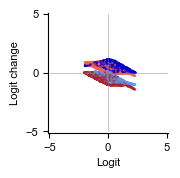

In [24]:
from plotting_experiments.plotting_dynamics import plot_all_models_value_change

dynamics_plot_pipeline = [
    '2d_logit_change', # logit vs logit change
]
plot_all_models_value_change(
    exp_folder, plots=dynamics_plot_pipeline, save_pdf=True)